In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Multi-Factor Models

## Implementing the CAPM in Python

### How to do it...

1. Import the libraries:

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm

2. Specify the risky asset and the time horizon:

In [4]:
RISKY_ASSET = 'AMZN'
MARKET_BENCHMARK = '^GSPC'
START_DATE = '2014-01-01'
END_DATE = '2018-12-31'

3. Download data from Yahoo Finance:

In [5]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 1257 rows of data.


4. Resample to monthly data and calculate simple returns:

In [6]:
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset', 
                                    MARKET_BENCHMARK: 'market'}) \
                   .resample('M') \
                   .last() \
                   .pct_change() \
                   .dropna()
X.head()

,asset,market
Date,,
2014-02-28,0.009507,0.043117
2014-03-31,-0.071058,0.006932
2014-04-30,-0.095847,0.006201
2014-05-31,0.027685,0.021030
2014-06-30,0.039130,0.019058


5. Calculate beta using the covariance approach: 

In [7]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance
beta

1.6296082618965537

6. Prepare the input and estimate CAPM as a linear regression:

In [8]:
# separate target
y = X.pop('asset')

# add constant
X = sm.add_constant(X)

# define and fit the regression model 
capm_model = sm.OLS(y, X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     32.77
Date:                Tue, 12 Sep 2023   Prob (F-statistic):           4.05e-07
Time:                        16:15:49   Log-Likelihood:                 75.313
No. Observations:                  59   AIC:                            -146.6
Df Residuals:                      57   BIC:                            -142.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0178      0.009      1.950      0.0

### There's more...

#### Risk-free rate (13 Week Treasury Bill)

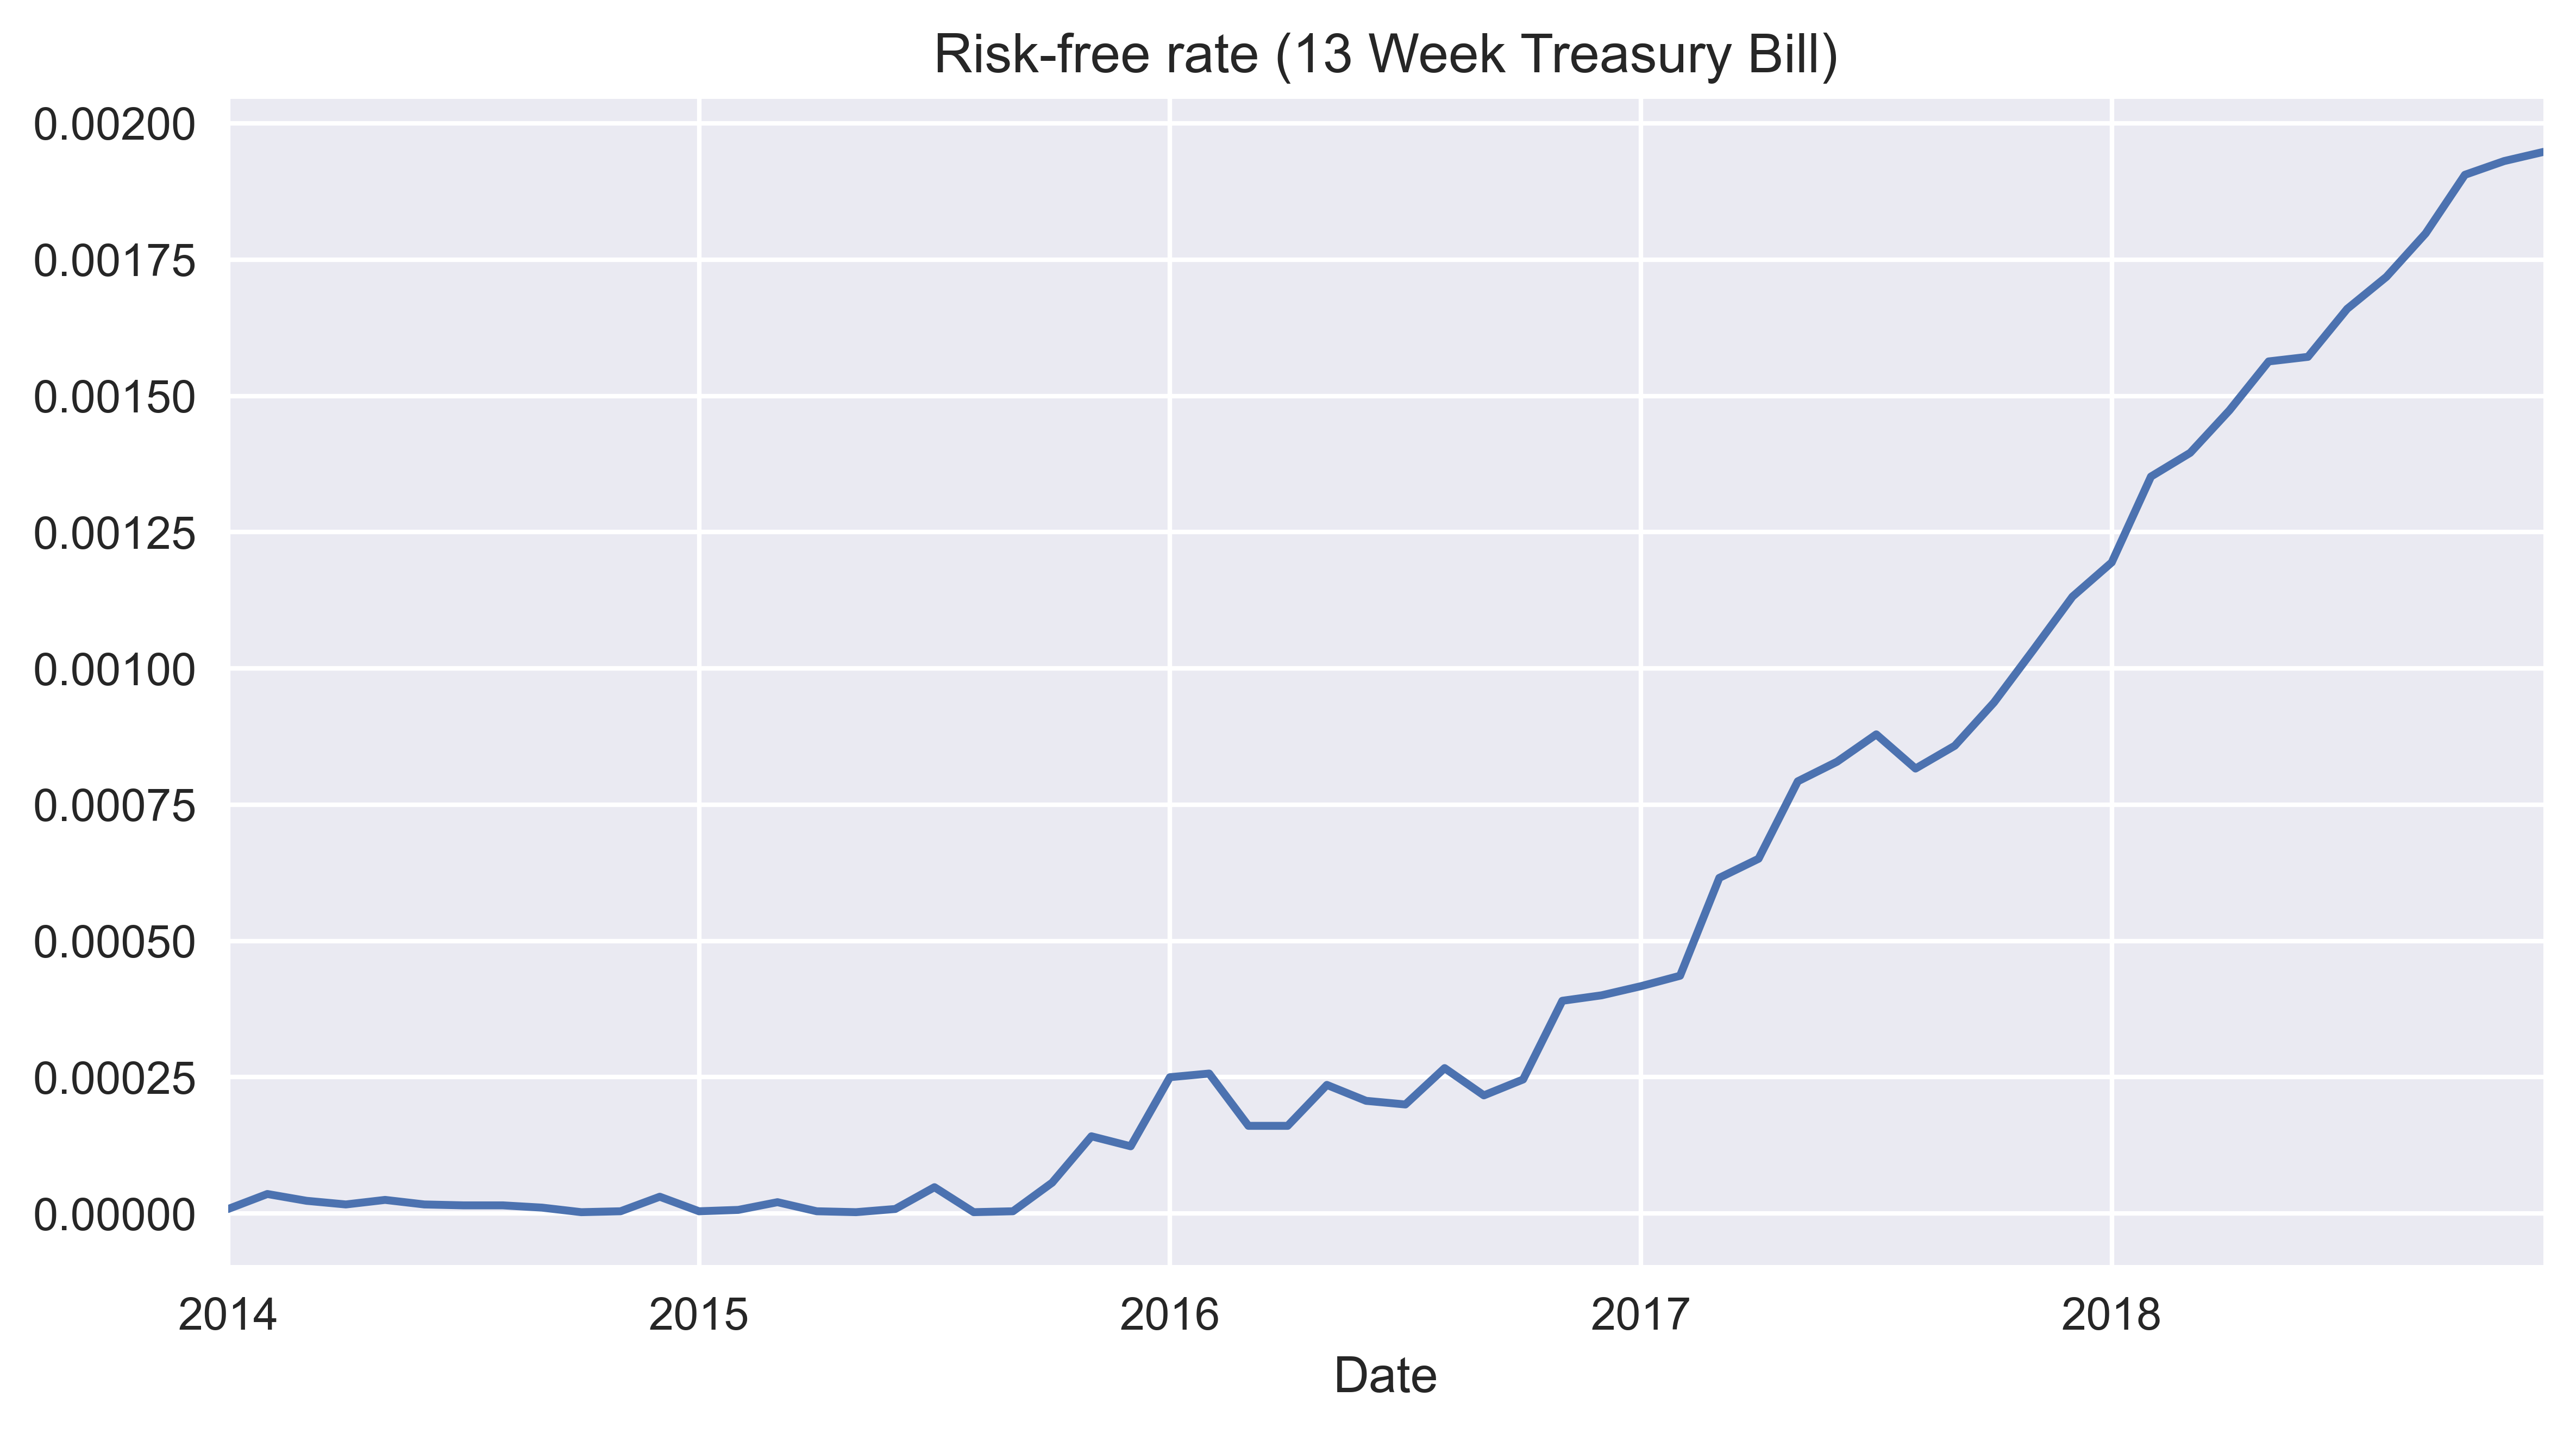

In [9]:
# period lenght in days
N_DAYS = 90

# download data from Yahoo finance
df_rf = yf.download('^IRX',
                    start=START_DATE,
                    end=END_DATE,
                    progress=False)

# resample to monthly by taking last value from each month
rf = df_rf.resample('M').last().Close / 100

# calculate the corresponding daily risk-free return  
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  

# convert to monthly and subtract 1
rf = (rf ** 30) - 1 

# plot the risk-free rate
rf.plot(title='Risk-free rate (13 Week Treasury Bill)')

plt.tight_layout()
# plt.savefig('images/ch4_im2.png')
plt.show()

#### Risk-free rate (3-Month Treasury Bill)

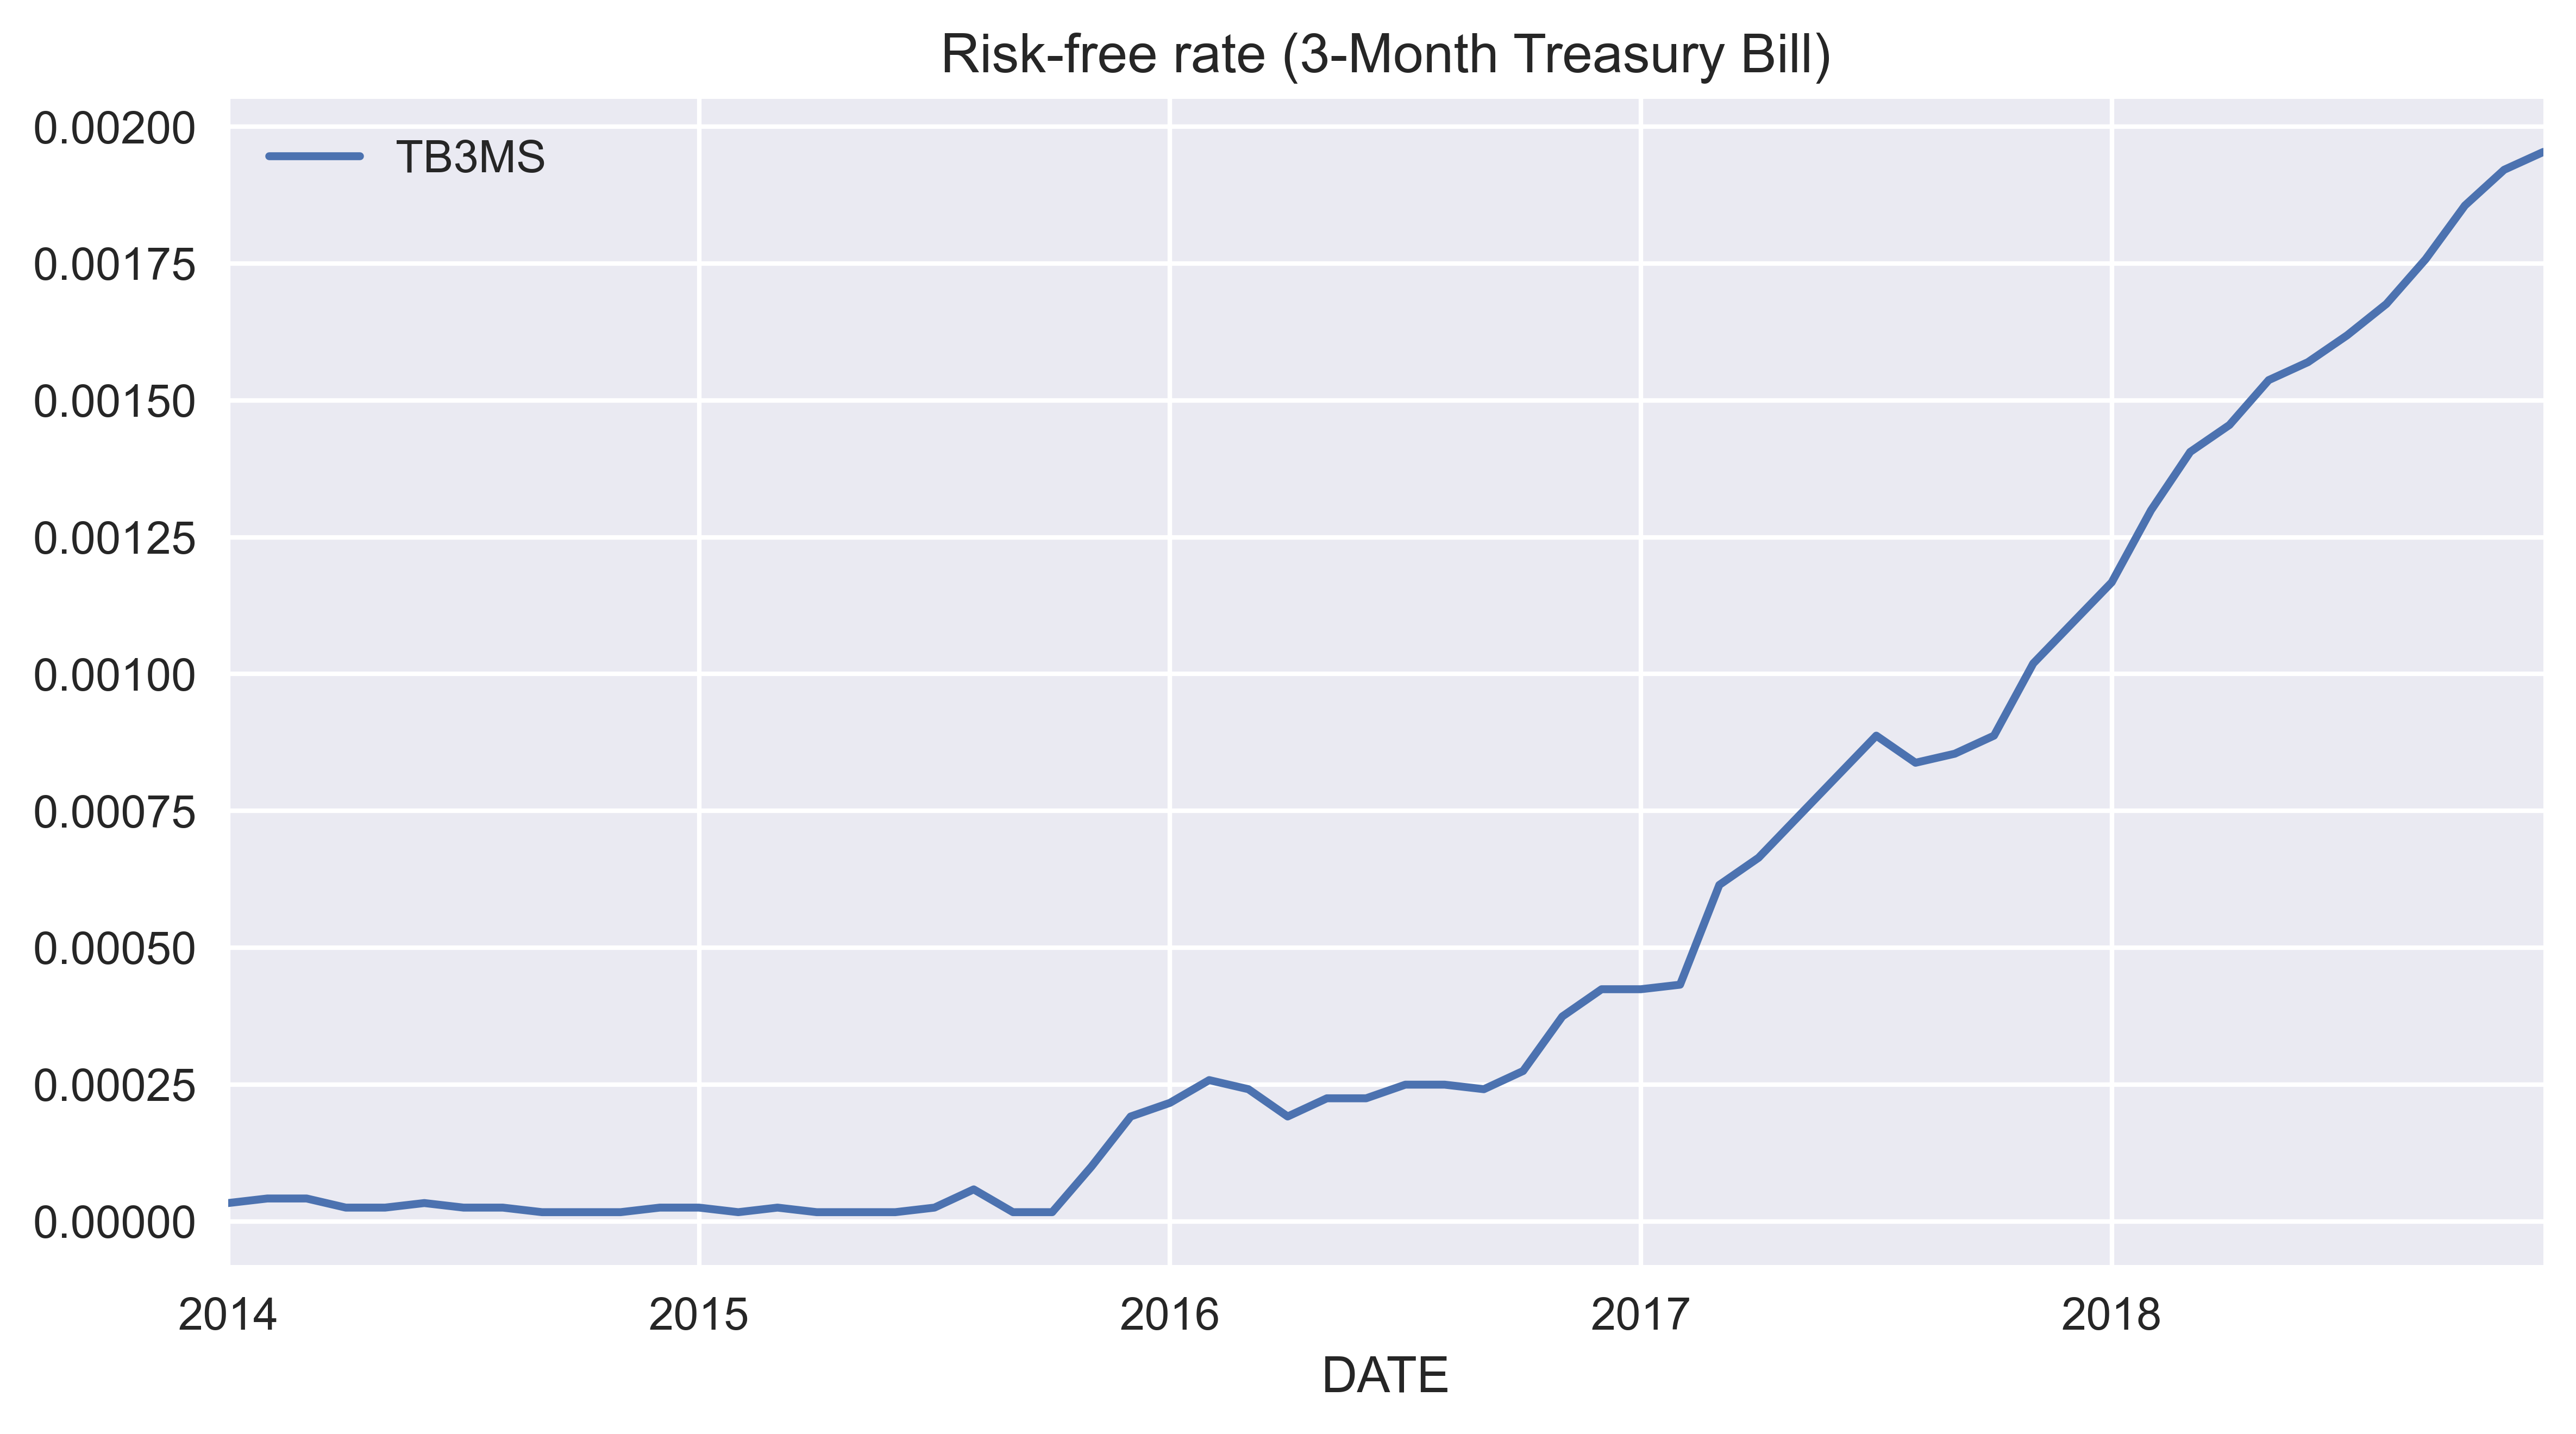

In [10]:
import pandas_datareader.data as web

# download the data 
rf = web.DataReader('TB3MS', 'fred', start=START_DATE, end=END_DATE)

# convert to monthly
rf = (1 + (rf / 100)) ** (1 / 12) - 1

# plot the risk-free rate
rf.plot(title='Risk-free rate (3-Month Treasury Bill)')

plt.tight_layout()
# plt.savefig('images/ch4_im3.png')
plt.show()

## Implementing the Fama-French three-factor model in Python

### How to do it...

1. Import the libraries:

In [11]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf

2. Download data from prof. French's website:

In [48]:
'''
# download the zip file from Prof. French's website
!wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip

# unpack the zip
!unzip -a F-F_Research_Data_Factors_CSV.zip

# remove the zip
!rm F-F_Research_Data_Factors_CSV.zip
'''

"\n# download the zip file from Prof. French's website\n!wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip\n\n# unpack the zip\n!unzip -a F-F_Research_Data_Factors_CSV.zip\n\n# remove the zip\n!rm F-F_Research_Data_Factors_CSV.zip\n"

3. Define parameters:

In [49]:
RISKY_ASSET = 'META'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

4. Load data from the source CSV file and keep only the monthly data:

In [50]:
# load data from csv
factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)

# identify where the annual data starts
STR_TO_MATCH = ' Annual Factors: January-December '
indices = factor_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_df[indices].index[0]

# keep only monthly data
factor_df = factor_df[factor_df.index < start_of_annual]

5. Rename columns of the DataFrame, set a datetime index and filter by dates:

In [51]:
# rename columns
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']

# convert strings to datetime
factor_df['date'] = pd.to_datetime(factor_df['date'], 
                                   format='%Y%m') \
                      .dt.strftime("%Y-%m")

# set index
factor_df = factor_df.set_index('date')

# filter only required dates
factor_df = factor_df.loc[START_DATE:END_DATE]

6. Convert the values to numeric and divide by 100:

In [52]:
factor_df = factor_df.apply(pd.to_numeric, 
                            errors='coerce') \
                     .div(100)
factor_df.head()

,mkt,smb,hml,rf
date,,,,
2014-01,-0.0332,0.0089,-0.0207,0.0
2014-02,0.0465,0.0035,-0.0031,0.0
2014-03,0.0043,-0.0181,0.0493,0.0
2014-04,-0.0019,-0.0419,0.0117,0.0
2014-05,0.0206,-0.0188,-0.0013,0.0


7. Download the prices of the risky asset:

In [53]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1258 rows of data.


8. Calculate monthly returns on the risky asset:

In [54]:
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'rtn'
y.head()

Date
2014-01    0.144922
2014-02    0.094135
2014-03   -0.120070
2014-04   -0.007636
2014-05    0.058883
Name: rtn, dtype: float64

9. Merge the datasets and calculate excess returns:

In [55]:
ff_data = factor_df.join(y)
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf

10. Estimate the three-factor model:

In [56]:
# define and fit the regression model 
ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', 
                   data=ff_data).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     5.127
Date:                Tue, 12 Sep 2023   Prob (F-statistic):            0.00333
Time:                        16:18:23   Log-Likelihood:                 88.334
No. Observations:                  60   AIC:                            -168.7
Df Residuals:                      56   BIC:                            -160.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0104      0.008      1.366      0.1

### There's more...

1. Import the libraries:

In [57]:
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

2. Print available datasets (here only first 5):

In [58]:
get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

3. Download the selected dataset:

In [59]:
ff_dict = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                         start='2014-01-01')

In [60]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

4. Inspect the description of the dataset

In [61]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202307 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2023 Kenneth R. French

  0 : (115 rows x 4 cols)
  1 : Annual Factors: January-December (9 rows x 4 cols)


5. View the monthly dataset:

In [62]:
ff_dict[0].head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2014-01,-3.32,0.89,-2.07,0.0
2014-02,4.65,0.35,-0.31,0.0
2014-03,0.43,-1.81,4.93,0.0
2014-04,-0.19,-4.19,1.17,0.0
2014-05,2.06,-1.88,-0.13,0.0


## Implementing the rolling three-factor model on a portfolio of assets

### How to do it...

1. Import the libraries:

In [63]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Define the parameters:

In [64]:
ASSETS = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = '2009-12-31'
END_DATE = '2018-12-31'

3. Download the factor related data:

In [65]:
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()

4. Download the prices of risky assets from Yahoo Finance:

In [66]:
asset_df = yf.download(ASSETS,
                       start=START_DATE,
                       end=END_DATE,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 2264 rows of data.


5. Calculate the monthly returns on the risky assets:

In [67]:
asset_df = asset_df['Adj Close'].resample('M') \
                                .last() \
                                .pct_change() \
                                .dropna()
# reformat index for joining
asset_df.index = asset_df.index.strftime('%Y-%m')

6. Calculate the portfolio returns:

In [68]:
asset_df['portfolio_returns'] = np.matmul(asset_df[ASSETS].values, 
                                          WEIGHTS)
asset_df.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2010-01,-0.088597,-0.067722,-0.145230,-0.075459,-0.094252
2010-02,0.065396,-0.055897,-0.005925,0.022146,0.006430
2010-03,0.148470,0.146706,0.076538,0.021625,0.098335
2010-04,0.111021,0.009796,-0.073036,0.042677,0.022615
2010-05,-0.016125,-0.084902,-0.076222,-0.151395,-0.082161


<AxesSubplot:xlabel='Date'>

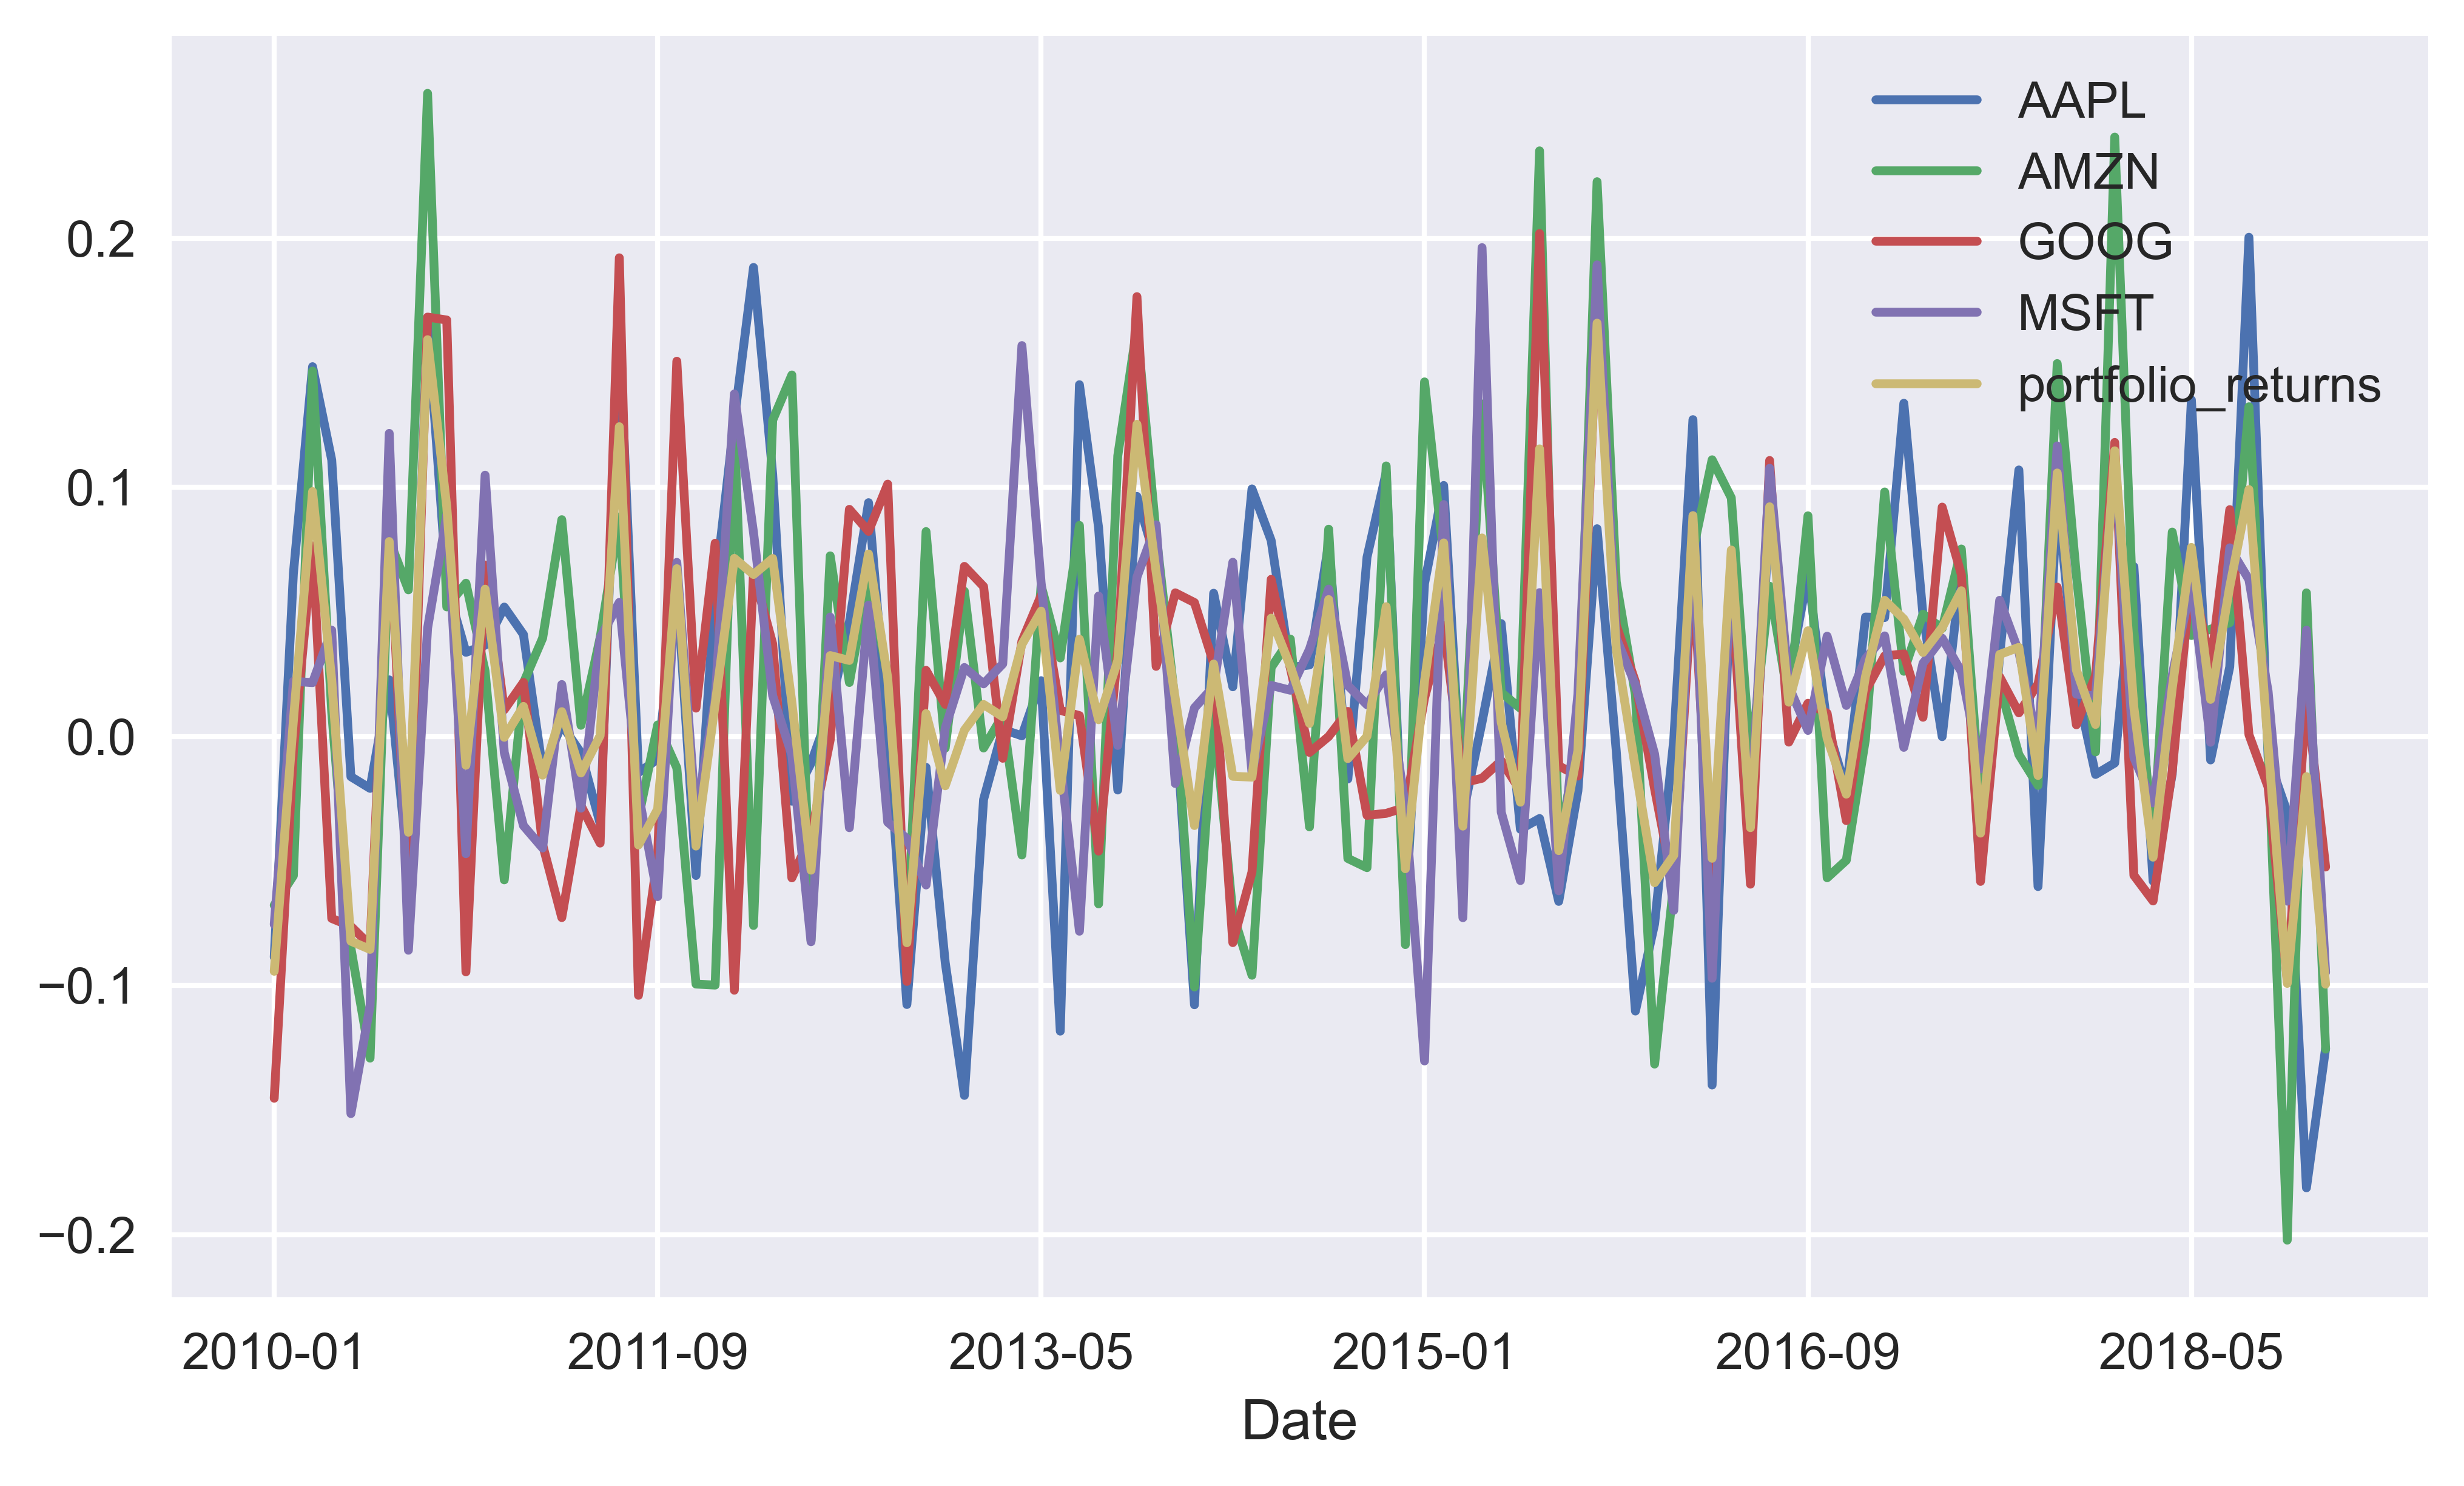

In [69]:
asset_df.plot()

7. Merge the datasets:

In [70]:
ff_data = asset_df.join(df_three_factor).drop(ASSETS, axis=1)
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf

In [71]:
ff_data.head()

,portf_rtn,mkt,smb,hml,rf,portf_ex_rtn
Date,,,,,,
2010-01,-0.094252,-0.0336,0.0040,0.0043,0.0000,-0.094252
2010-02,0.006430,0.0340,0.0119,0.0323,0.0000,0.006430
2010-03,0.098335,0.0631,0.0148,0.0221,0.0001,0.098235
2010-04,0.022615,0.0200,0.0487,0.0289,0.0001,0.022515
2010-05,-0.082161,-0.0789,0.0009,-0.0244,0.0001,-0.082261


8. Define a function for the rolling n-factor model

In [72]:
def rolling_factor_model(input_data, formula, window_size):
    '''
    Function for estimating the Fama-French (n-factor) model using a rolling window of fixed size.
    
    Parameters
    ------------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns
    formula : str
        `statsmodels` compatible formula representing the OLS regression  
    window_size : int
        Rolling window length.
    
    Returns
    -----------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the three factors for each iteration.
    '''

    coeffs = []

    for start_index in range(len(input_data) - window_size + 1):        
        end_index = start_index + window_size

        # define and fit the regression model 
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_index:end_index]
        ).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

9. Estimate the rolling three-factor model and plot the results:

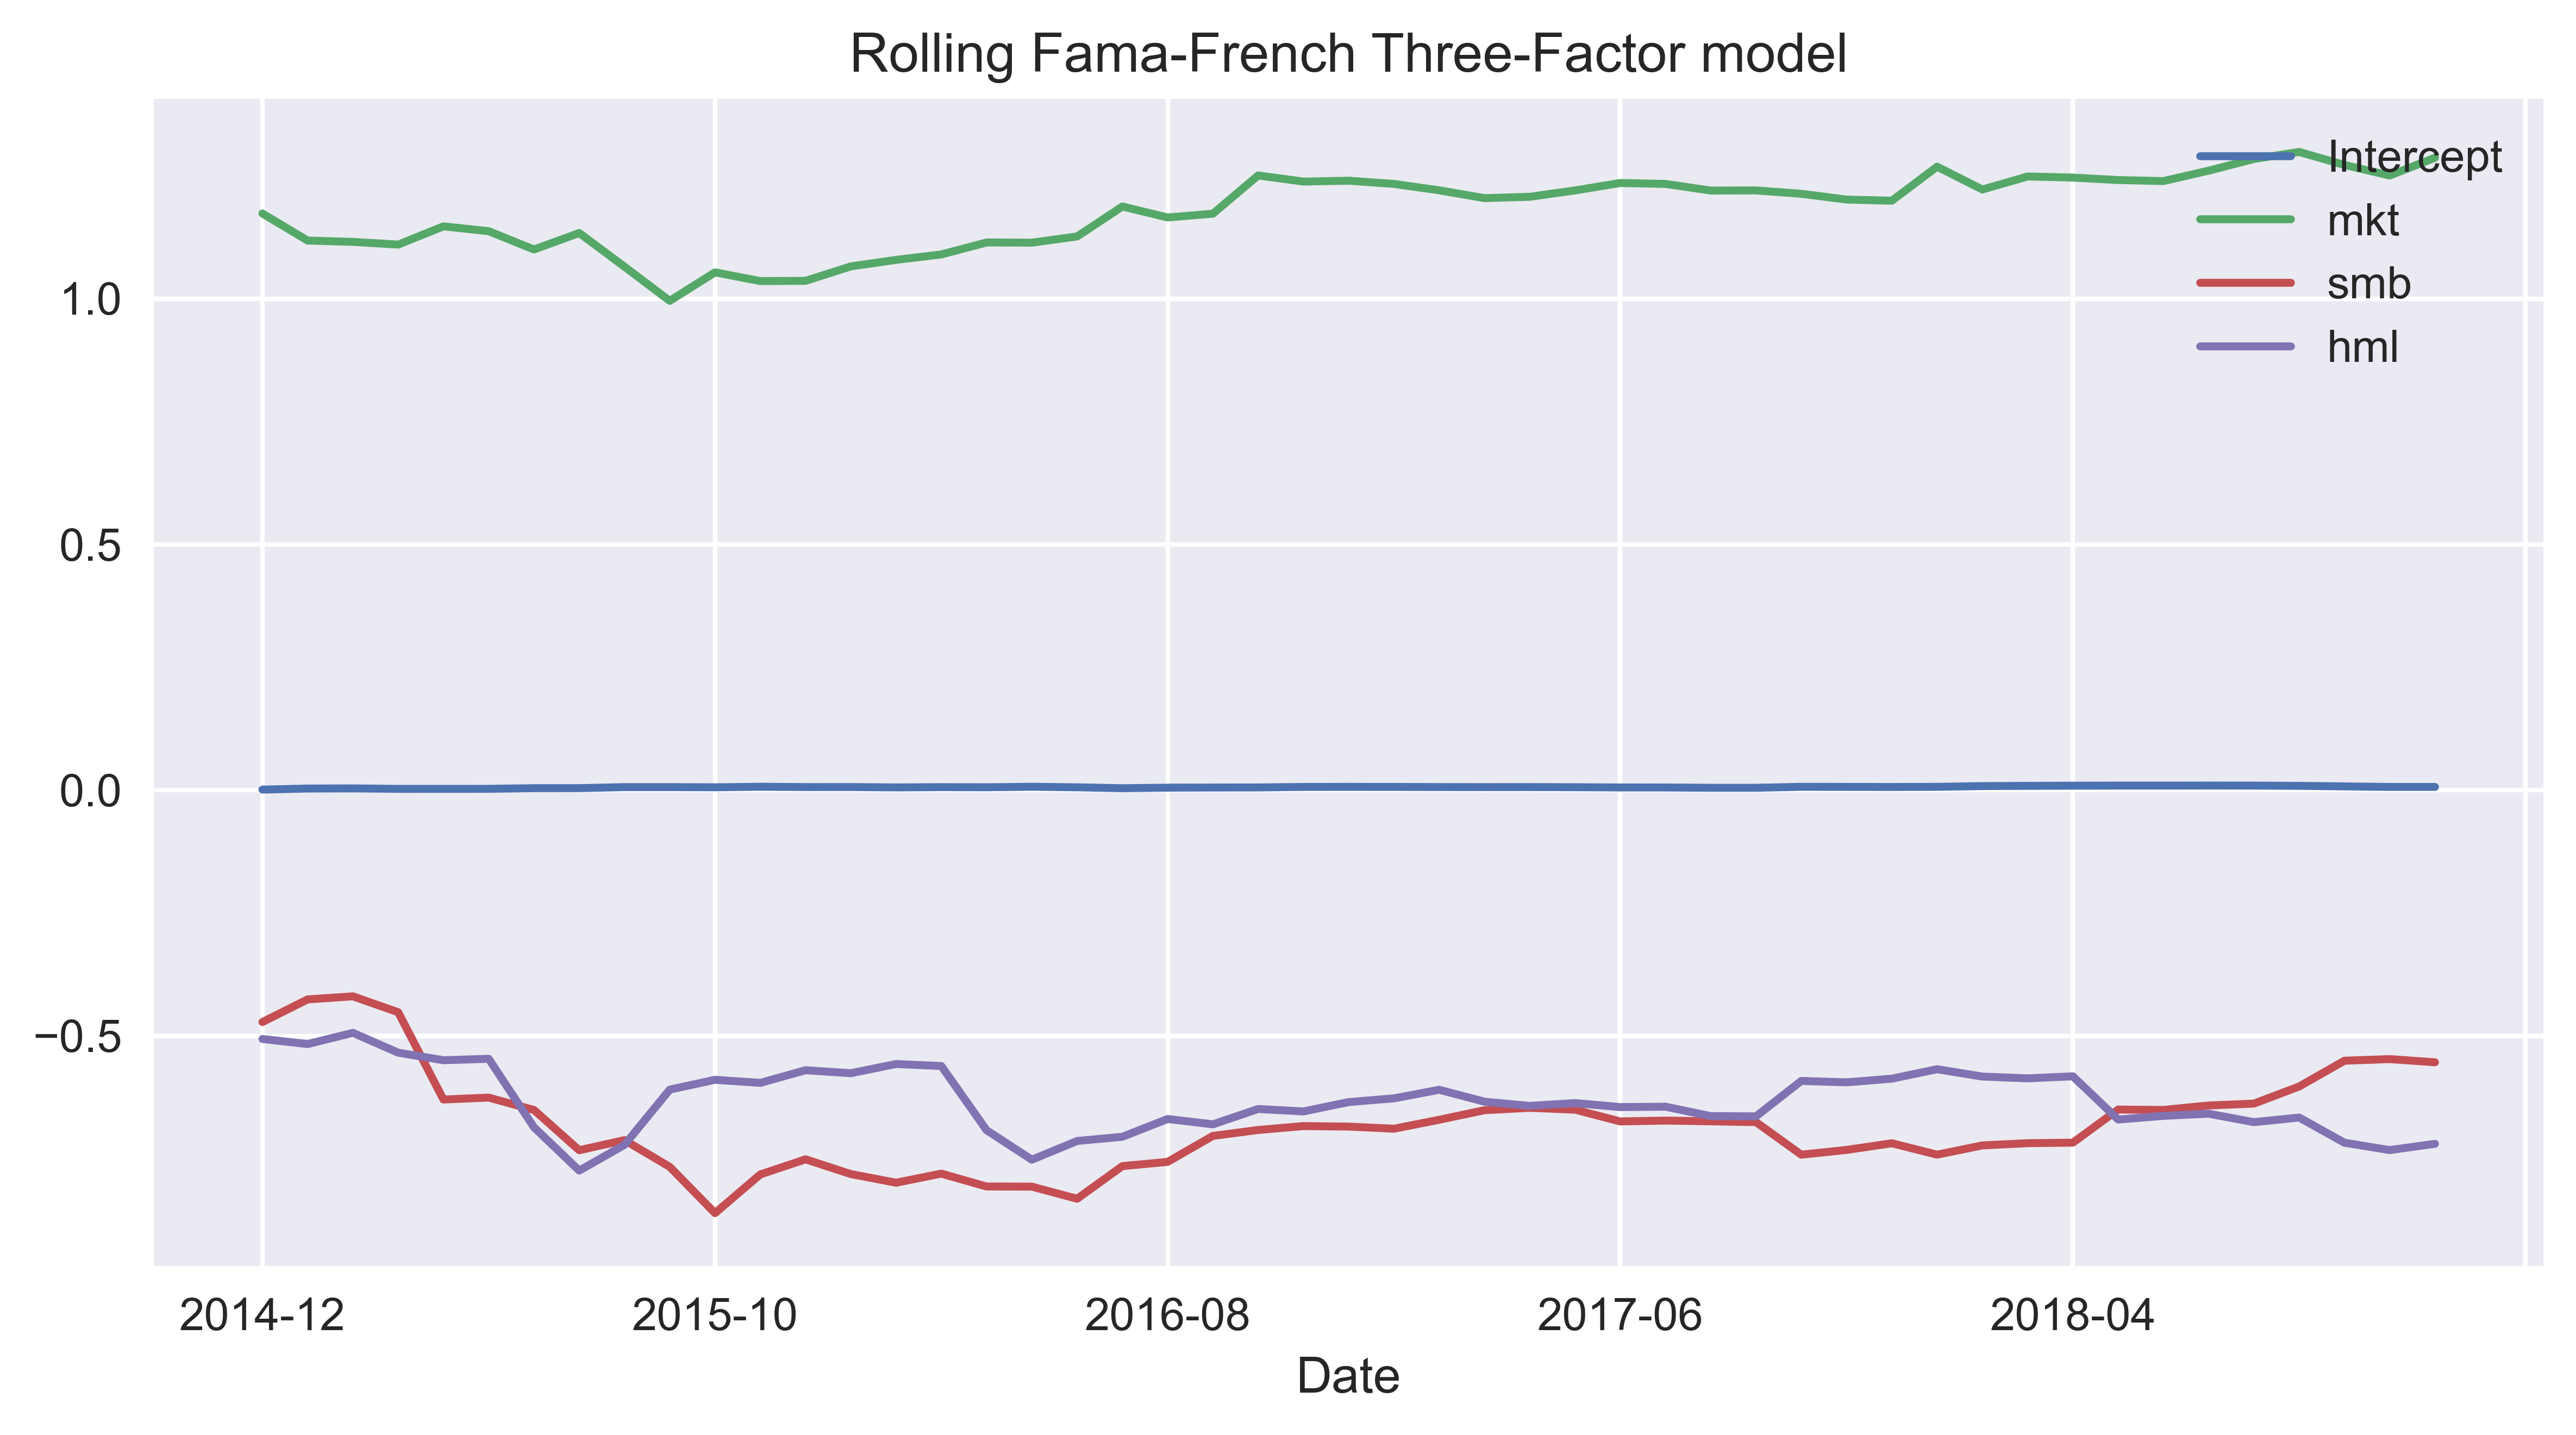

In [73]:
MODEL_FORMULA = 'portf_ex_rtn ~ mkt + smb + hml'
results_df = rolling_factor_model(ff_data, 
                                  MODEL_FORMULA, 
                                  window_size=60)
results_df.plot(title = 'Rolling Fama-French Three-Factor model')

plt.tight_layout()
# plt.savefig('images/ch4_im8.png')
plt.show()

## Implementing the four- and five-factor models in Python

### How to do it...

1. Import the libraries:

In [74]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Specify the risky asset and the time horizon:

In [75]:
RISKY_ASSET = 'AMZN'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

3. Download the risk factors from prof. French's website:

In [76]:
# three factors 
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]
df_three_factor.index = df_three_factor.index.format()

# momentum factor
df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', 
                        start=START_DATE)[0]
df_mom.index = df_mom.index.format()

# five factors
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                                'famafrench', 
                                start=START_DATE)[0]
df_five_factor.index = df_five_factor.index.format()

4. Download the data of the risky asset from Yahoo Finance:

In [77]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1258 rows of data.


5. Calculate monthly returns:

In [78]:
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.index = [str(x) for x in y.index]
y.name = 'return'

6. Merge the datasets for the four-factor models:

In [79]:
# join all datasets on the index
four_factor_data = df_three_factor.join(df_mom).join(y)

# rename columns
four_factor_data.columns = ['mkt', 'smb', 'hml', 'rf', 'mom', 'rtn']

# divide everything (except returns) by 100
four_factor_data.loc[:, four_factor_data.columns != 'rtn'] /= 100

# convert index to datetime
four_factor_data.index = pd.to_datetime([str(x) for x in four_factor_data.index], 
                                        format='%Y-%m')

# select period of interest
four_factor_data = four_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
four_factor_data['excess_rtn'] = four_factor_data.rtn - four_factor_data.rf

four_factor_data.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
2014-01-01,-0.0332,0.0089,-0.0207,0.0,0.0171,-0.100554,-0.100554
2014-02-01,0.0465,0.0035,-0.0031,0.0,0.0207,0.009507,0.009507
2014-03-01,0.0043,-0.0181,0.0493,0.0,-0.0329,-0.071058,-0.071058
2014-04-01,-0.0019,-0.0419,0.0117,0.0,-0.0389,-0.095847,-0.095847
2014-05-01,0.0206,-0.0188,-0.0013,0.0,0.0087,0.027685,0.027685


In [80]:
four_factor_data

,mkt,smb,hml,rf,mom,rtn,excess_rtn
2014-01-01,-0.0332,0.0089,-0.0207,0.0000,0.0171,-0.100554,-0.100554
2014-02-01,0.0465,0.0035,-0.0031,0.0000,0.0207,0.009507,0.009507
2014-03-01,0.0043,-0.0181,0.0493,0.0000,-0.0329,-0.071058,-0.071058
2014-04-01,-0.0019,-0.0419,0.0117,0.0000,-0.0389,-0.095847,-0.095847
2014-05-01,0.0206,-0.0188,-0.0013,0.0000,0.0087,0.027685,0.027685
2014-06-01,0.0261,0.0309,-0.0070,0.0000,0.0069,0.039130,0.039130
2014-07-01,-0.0204,-0.0429,0.0003,0.0000,-0.0012,-0.036302,-0.036302
2014-08-01,0.0424,0.0040,-0.0045,0.0000,0.0082,0.083229,0.083229
2014-09-01,-0.0197,-0.0371,-0.0134,0.0000,0.0050,-0.048962,-0.048962
2014-10-01,0.0252,0.0421,-0.0181,0.0000,-0.0006,-0.052661,-0.052661


7. Merge the datasets for the five-factor models:

In [81]:
# join all datasets on the index
five_factor_data = df_five_factor.join(y)

# rename columns
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'rtn']

# divide everything (except returns) by 100
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100

# convert index to datetime
five_factor_data.index = pd.to_datetime([str(x) for x in five_factor_data.index], 
                                        format='%Y-%m')

# select period of interest
five_factor_data = five_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
five_factor_data['excess_rtn'] = five_factor_data.rtn - five_factor_data.rf

five_factor_data.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
2014-01-01,-0.0332,0.0058,-0.0207,-0.0388,-0.0142,0.0,-0.100554,-0.100554
2014-02-01,0.0465,0.0014,-0.0031,-0.0023,-0.0045,0.0,0.009507,0.009507
2014-03-01,0.0043,-0.0109,0.0493,0.0213,0.0192,0.0,-0.071058,-0.071058
2014-04-01,-0.0019,-0.0412,0.0117,0.0348,0.0102,0.0,-0.095847,-0.095847
2014-05-01,0.0206,-0.0189,-0.0013,0.0005,-0.0100,0.0,0.027685,0.027685


8. Estimate the four-factor model:

In [82]:
four_factor_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml + mom', 
                            data=four_factor_data).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     16.90
Date:                Tue, 12 Sep 2023   Prob (F-statistic):           4.30e-09
Time:                        16:18:34   Log-Likelihood:                 86.372
No. Observations:                  60   AIC:                            -162.7
Df Residuals:                      55   BIC:                            -152.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0093      0.008      1.162      0.2

9. Estimate the five-factor model:

In [83]:
five_factor_model = smf.ols(
    formula='excess_rtn ~ mkt + smb + hml + rmw + cma', 
    data=five_factor_data
).fit()

print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     15.86
Date:                Tue, 12 Sep 2023   Prob (F-statistic):           1.36e-09
Time:                        16:18:35   Log-Likelihood:                 89.430
No. Observations:                  60   AIC:                            -166.9
Df Residuals:                      54   BIC:                            -154.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0100      0.008      1.297      0.2